# Read data from CSV files


## Import libraries

In [1]:
import pandas as pd
import numpy as np

## Read data function

In [2]:
def read_csv_to_dataframe(filename):
    df = pd.read_csv(filename)
    return df

## Visualize Adjusted Close

In [3]:
filename = './data/ONGC.NS.csv'
df = read_csv_to_dataframe(filename)

<Axes: >

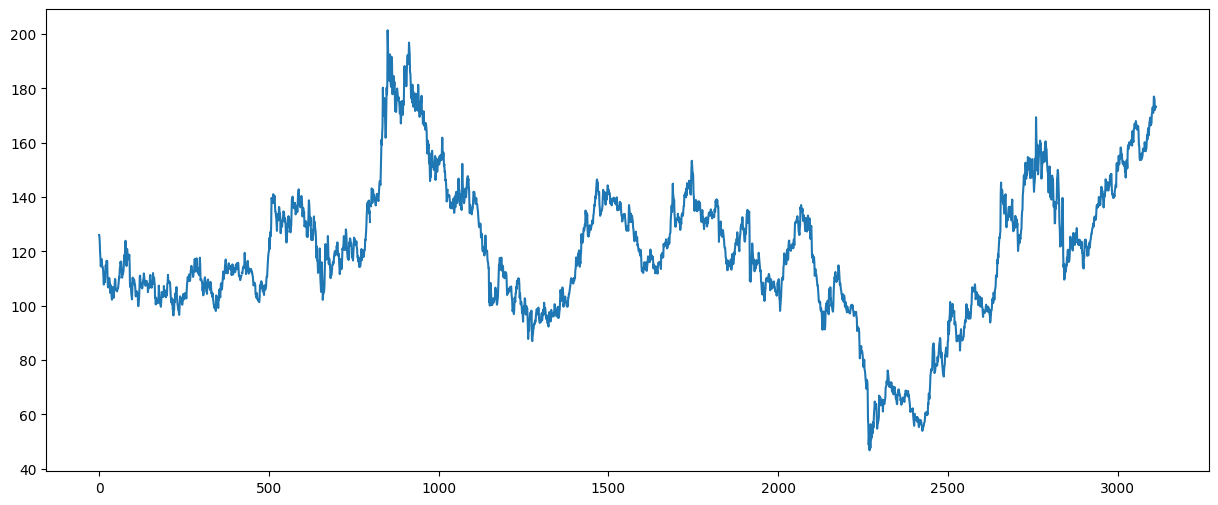

In [4]:
df['Adj Close'].plot(figsize=(15, 6))

# Calculate historical returns

We calculate Historical returns based on Adj Close (Adjusted Close Price).

We denote Historical returns as $R$, Adj Close as $AC$.

The original formula is: $R_t = \frac{AC_{t} - AC_{t-1}}{AC_{t-1}} * 100$.

Let calculate and make a plot with the data of **ONGC (Oil And Natural Gas Corporation)** Company as an example.

/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/2143120690.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Adj Close'].pct_change()


<Axes: >

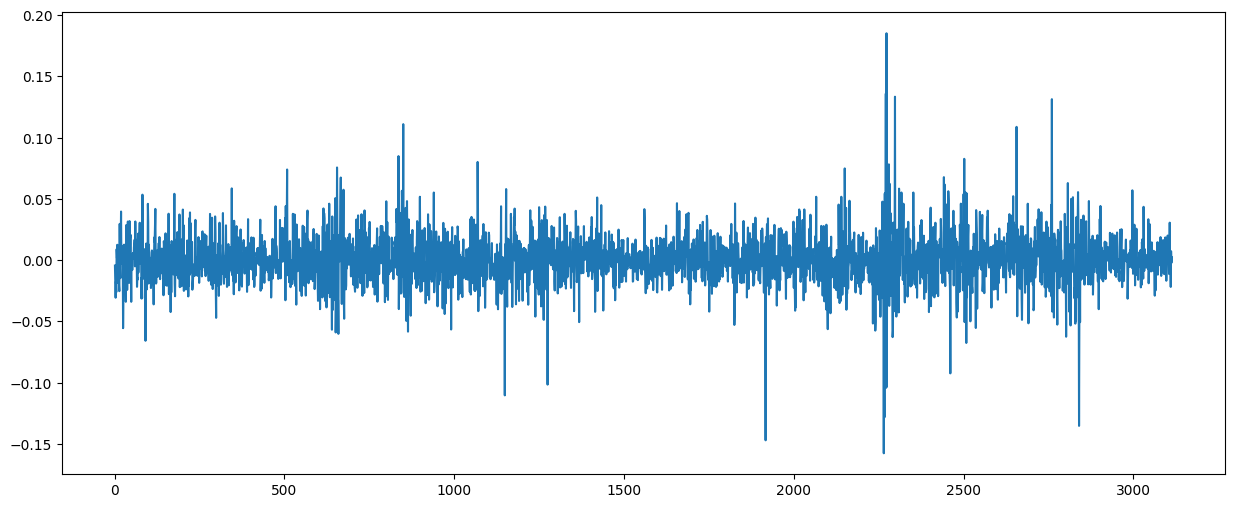

In [5]:
return_df = df[['Date', 'Adj Close']]
return_df['Historical Return'] = return_df['Adj Close'].pct_change()
return_df = return_df.dropna()
return_df['Historical Return'].plot(figsize=(15,6))

<Axes: >

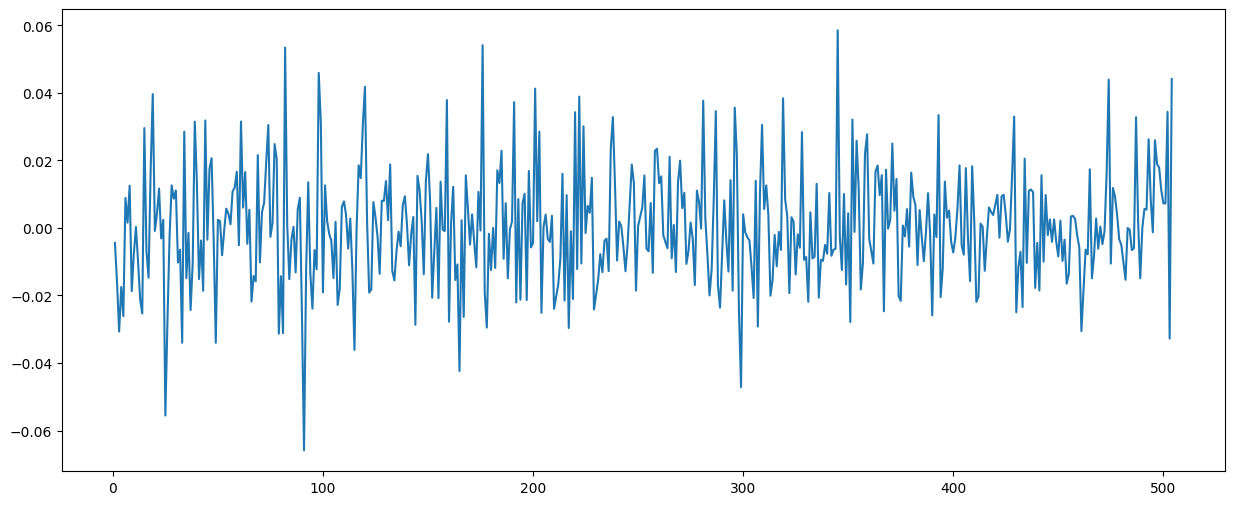

In [6]:
# Plot with 0-500 data 
return_df['Historical Return'].iloc[0:500].plot(figsize=(15,6))

These plots show that the original formula is very sensitive to price fluctuations, and maybe not suitable for forecasting. 

We decide looking for a return calculation method that is less sensitve.

Then, we found **EMA (Exponential Moving Average) returns**. The EMA is a type of moving average that gives more weight to recent data points, which can help smooth out the fluctuations and provide a more stable return series.

When applying EMA, we calculate Historical Return following 3 steps:

* Calculate the daily returns using the formula: $Daily Return_t = \frac{AC_{t} - AC_{t-1}}{AC_{t-1}}$

* Calculate the smoothing factor (alpha) for the EMA: $\alpha = \frac{2}{period + 1}$

* Calculate the Historical return for each day using the formula: $R_t = R_{t-1} + \alpha*(Daily Return_t - R_{t-1})$

Let's continuing our experiments about  **ONGC** with EMA-60days (Period of 2 month)

/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/854259250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/854259250.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()


<Axes: >

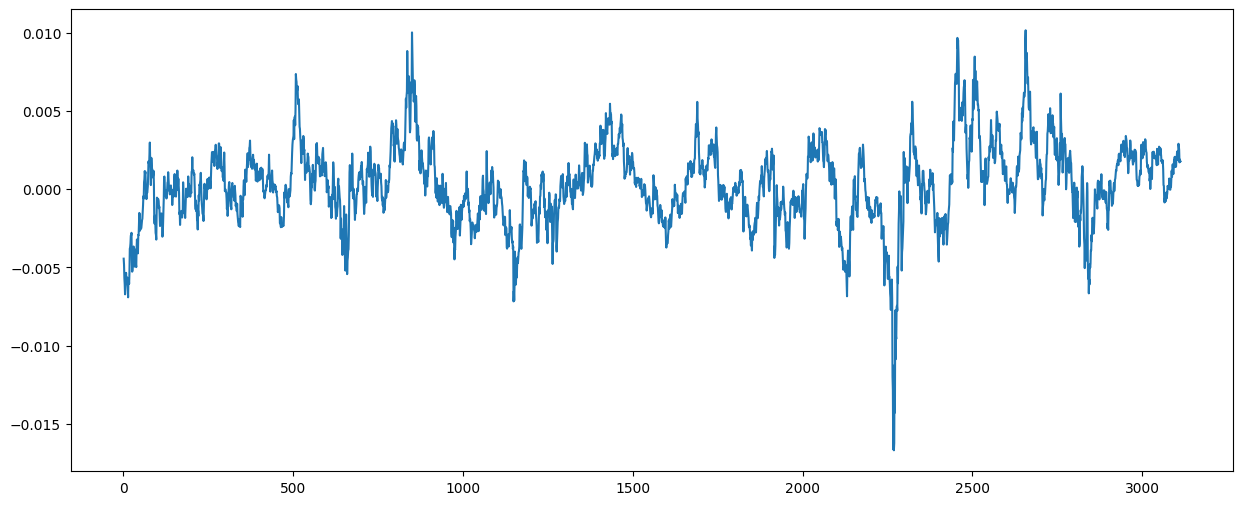

In [8]:
return_df = df[['Date', 'Adj Close']]

# Calculate Daily returns
return_df['Daily Return'] = return_df['Adj Close'].pct_change()

# Set the smoothing factor (alpha) for EMA
alpha = 2/(60 + 1)

# Calculate Historical returns
return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
return_df['Historical Return'].plot(figsize=(15,6))

<Axes: >

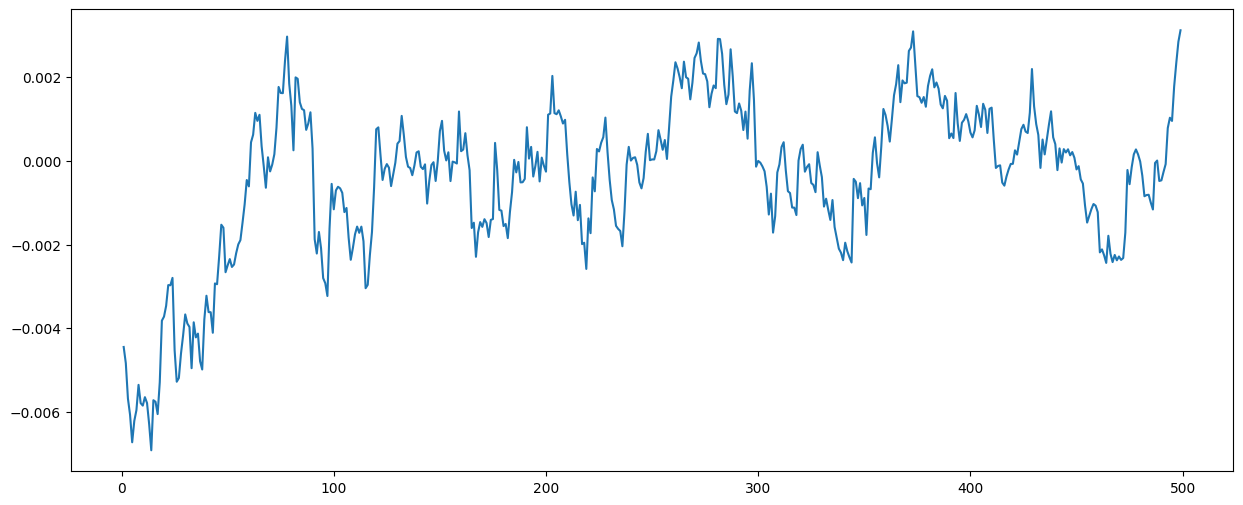

In [9]:
return_df['Historical Return'].iloc[0:500].plot(figsize=(15,6))

It looks better, let's move to the next step - model.

Before that, we define a function which can get csv data, calculate Historical return and split them following the 80-20 ratio for trainning model.

In [10]:
# Import libraries
from sklearn.model_selection import train_test_split as tts

# Function
def get_data(filename, period):
    df = read_csv_to_dataframe(filename)
    return_df = df[['Date', 'Adj Close']]

    # Calculate Daily returns
    return_df['Daily Return'] = return_df['Adj Close'].pct_change()

    # Set the smoothing factor (alpha) for EMA
    alpha = 2/(period + 1)

    # Calculate EMA returns
    return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()

    # Save current return for predicting
    current_return = return_df['Historical Return'].iloc[-1]

    # Create Predict column
    return_df['Predict'] = return_df['Historical Return'].shift(1)
    return_df = return_df.dropna()

    # Split dataset
    train_df, test_df = tts(return_df[['Historical Return', 'Predict']], train_size = 0.8, shuffle = False)
    x_train = train_df.drop(columns = ['Predict'])
    y_train = train_df['Predict']
    x_test= test_df.drop(columns = ['Predict'])
    y_test = test_df['Predict']
    return x_train, y_train, x_test, y_test, current_return, alpha

# Model

* **Goal:** Based on the Historical return of a certain stock, feed the data into a prediction model and use that data to make predictions about the future returs of that stock.

* **Method:** Bagging Ensemble Learning. (Train more than one models. Each model will be trained independently. The results based on all model results.)

* **Models:** 
    * Linear Regression 

    * Gradient Boosting Tree 
    
    * k-Nearest Neighbors

* **Evaluate:** 
    * RMSE (Root Mean Squared Error) 

    * R-Squared

In [11]:
# Import libraries
import numpy as np
import pandas as pd
from xgboost import XGBRegressor as regressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statistics import mean

In [12]:
# k-Nearest Neighbors model
def knn_df(filename, period):
     # Get data
     x_train, y_train, x_test, y_test, current_return, alpha = get_data(filename, period)
     
     # Model training and evaluating
     model = KNeighborsRegressor(n_neighbors=5)
     model.fit(x_train, y_train)
     print(model.score(x_test, y_test))
     
     # Model predicting
     predict = model.predict(x_test)
     print("kNN RMSE: ", mean_squared_error(y_test, predict))
     predict_df = pd.DataFrame({'predict': predict,'real':y_test}, index = None)

     # Future predicting
     cur_return = current_return
     predict_return_list = []
     for i in range(30):
          tmp_return = cur_return
          predict_return = model.predict([[tmp_return]])
          predict_return_list.append(predict_return[0])
          cur_return=predict_return[0]
     
     predict_df = pd.DataFrame({'Predicted Returns': np.concatenate((predict, predict_return_list), axis=0)}, index = None)
     y_test = y_test.reset_index()
     y_test = y_test.drop(columns='index')
     real_df = pd.DataFrame({'Real Returns': y_test['Predict']}, index = None)
     average_predict = mean(predict_return_list)
     return predict_df, real_df, average_predict

In [13]:
# Linear Regression model
def linear_df(filename, period):
    # Get data
    x_train, y_train, x_test, y_test, current_return, alpha = get_data(filename, period)

    # Model trainning and evaluating
    model = LinearRegression()
    model.fit(x_train, y_train)
    print(model.score(x_test, y_test))

    # Model predicting
    predict = model.predict(x_test)
    print("LR RMSE: ", mean_squared_error(y_test, predict))
    
    # Future predicting
    cur_return = current_return
    predict_return_list = []
    for i in range(30):
        tmp_return = cur_return
        predict_return = model.predict([[tmp_return]])
        predict_return_list.append(predict_return[0])
        cur_return=predict_return[0]
     
    predict_df = pd.DataFrame({'Predicted Returns': np.concatenate((predict, predict_return_list), axis=0)}, index = None)
    y_test = y_test.reset_index()
    y_test = y_test.drop(columns='index')
    real_df = pd.DataFrame({'Real Returns': y_test['Predict']}, index = None)
    average_predict = mean(predict_return_list)
    return predict_df, real_df, average_predict    

In [14]:
## Gradient Boosting Tree model
def xgb_df(filename, period):
    # Get data
    x_train, y_train, x_test, y_test, current_return, alpha = get_data(filename, period)

    # Model training and evaluating
    x_train, x_val, y_train, y_val = tts(x_train, y_train, train_size = 0.8, shuffle = False) 
    model = regressor(learning_rate = 0.06, max_depth = 6, n_estimators = 120)
    model.fit(x_train,y_train, eval_set = [(x_val, y_val)], eval_metric = 'rmse', verbose = False)
    print(model.score(x_test, y_test))

    # Model predicting
    predict = model.predict(x_test)
    print("GB RMSE: ", mean_squared_error(y_test, predict))

    # Future predicting
    df = pd.DataFrame({'Historical Return': [current_return]})
    predict_return_list = []
    for i in range(30):
        tmp_df = df
        predict_return = model.predict(tmp_df)
        predict_return_list.append(predict_return[0])
        df = pd.DataFrame({'Historical Return': [predict_return[0]]})
    
    predict_df = pd.DataFrame({'Predicted Returns': np.concatenate((predict, predict_return_list), axis=0)}, index = None)
    y_test = y_test.reset_index()
    y_test = y_test.drop(columns='index')
    real_df = pd.DataFrame({'Real Returns': y_test['Predict']}, index = None)
    average_predict = mean(predict_return_list)
    return predict_df, real_df, average_predict

In [15]:
def plot_result(predict_df, real_df):
    ax = predict_df.plot(figsize=(15,6))
    real_df.plot(ax=ax)

## Oil and Natural Gas Corporation Limited (ONGC)

0.8979094361307673
kNN RMSE:  5.451921235014817e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.16792193403528705

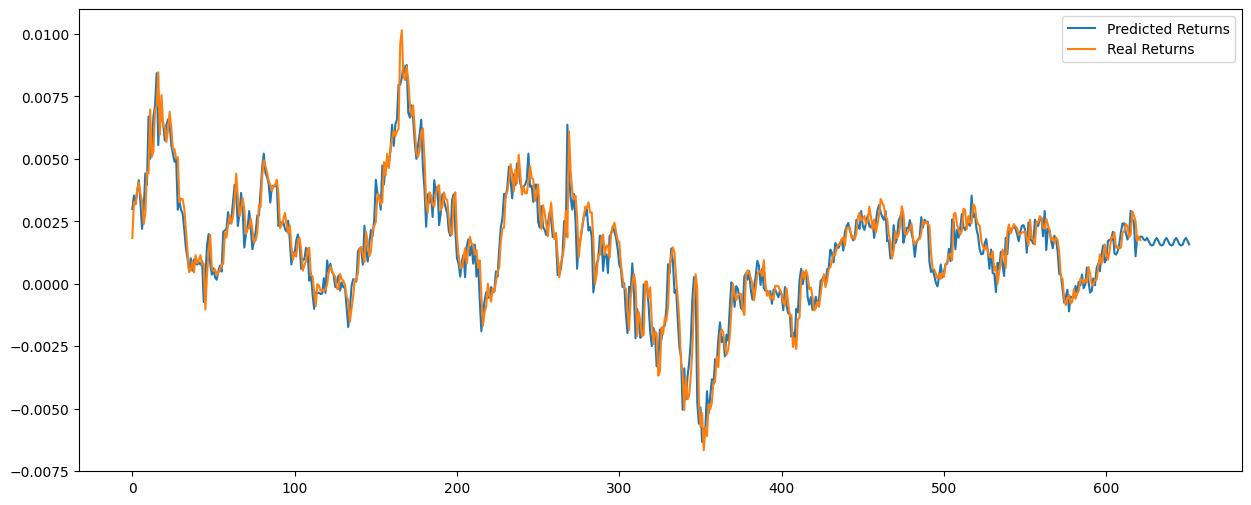

In [17]:
predict_df, real_df, average_predict = knn_df('./data/ONGC.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9093967299318535
LR RMSE:  4.83846766366208e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.10009156045214032

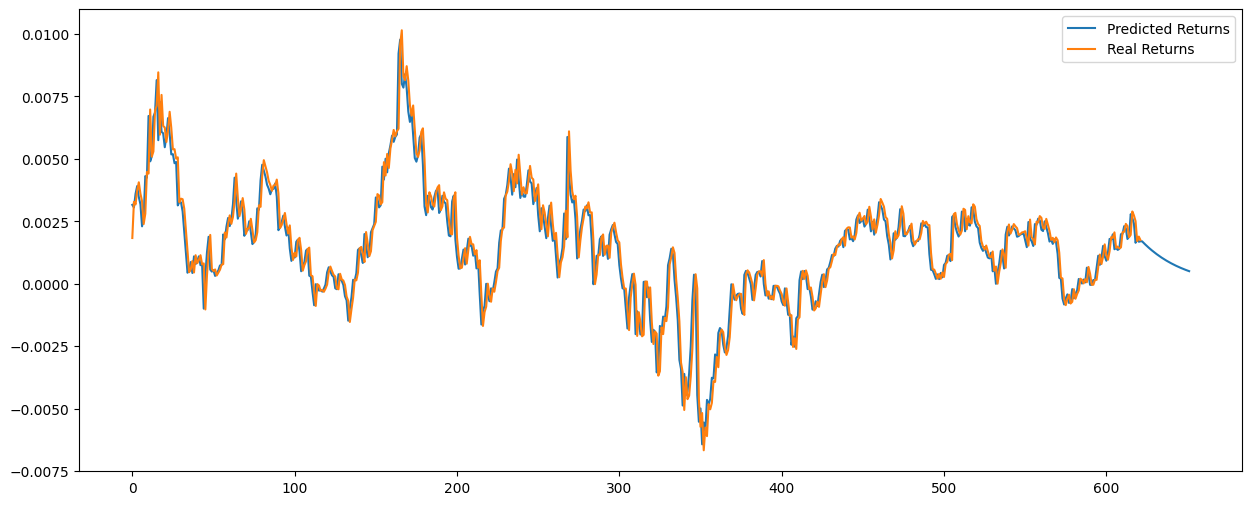

In [18]:
predict_df, real_df, average_predict = linear_df('./data/ONGC.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.8965469266736423
GB RMSE:  5.524683045320062e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.2876368351280689

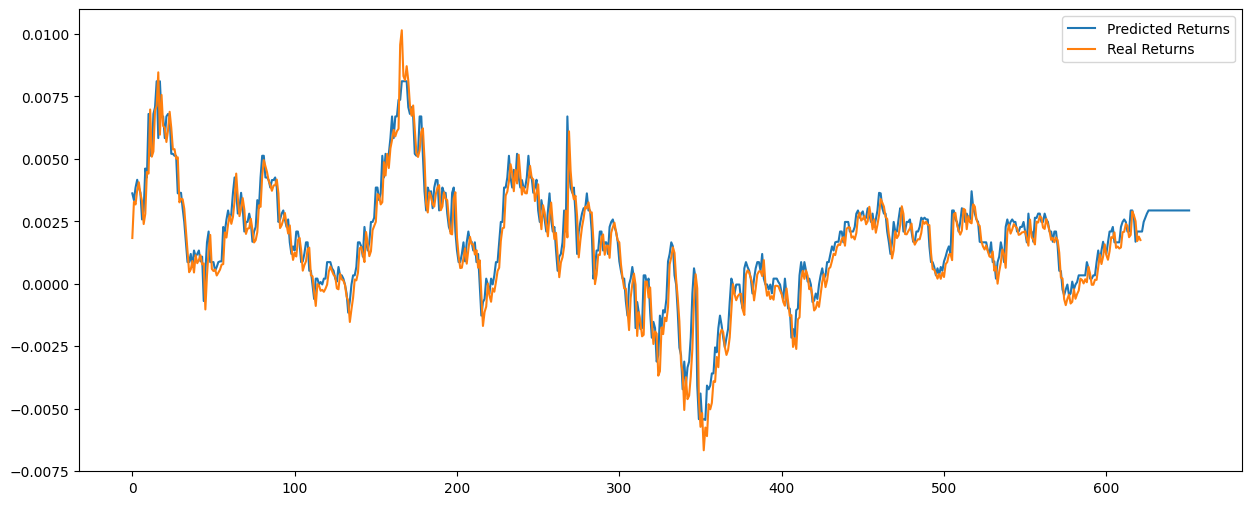

In [19]:
predict_df, real_df, average_predict = xgb_df('./data/ONGC.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

## Oil India Limited (OIL)

0.8670558766031564
kNN RMSE:  1.0298629362708567e-06


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.2780558223263928

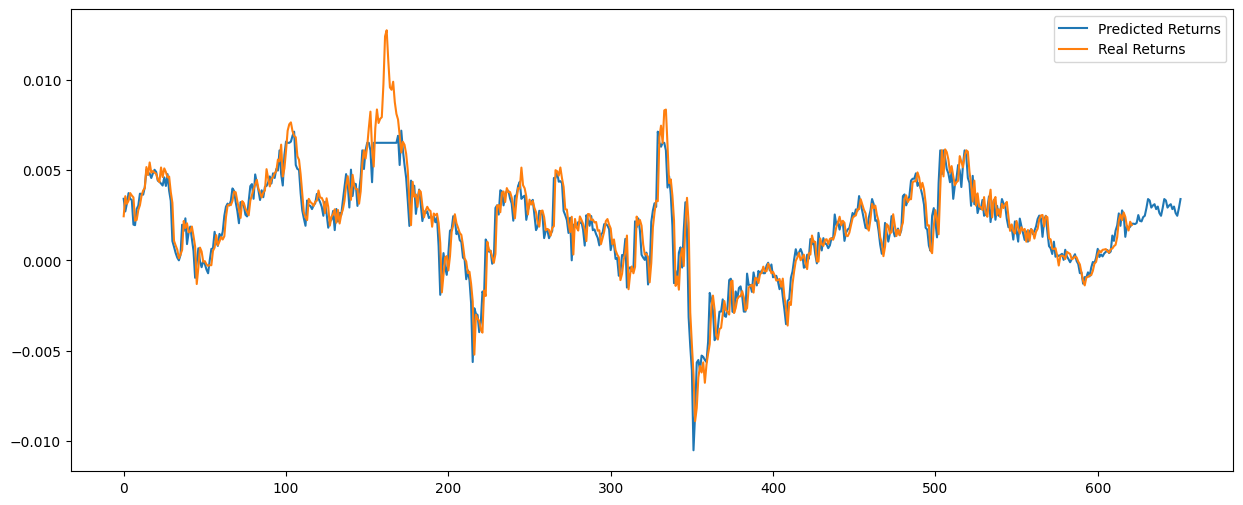

In [20]:
predict_df, real_df, average_predict = knn_df('./data/OIL.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9108315559132811
LR RMSE:  6.907509207889687e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.11306106632501861

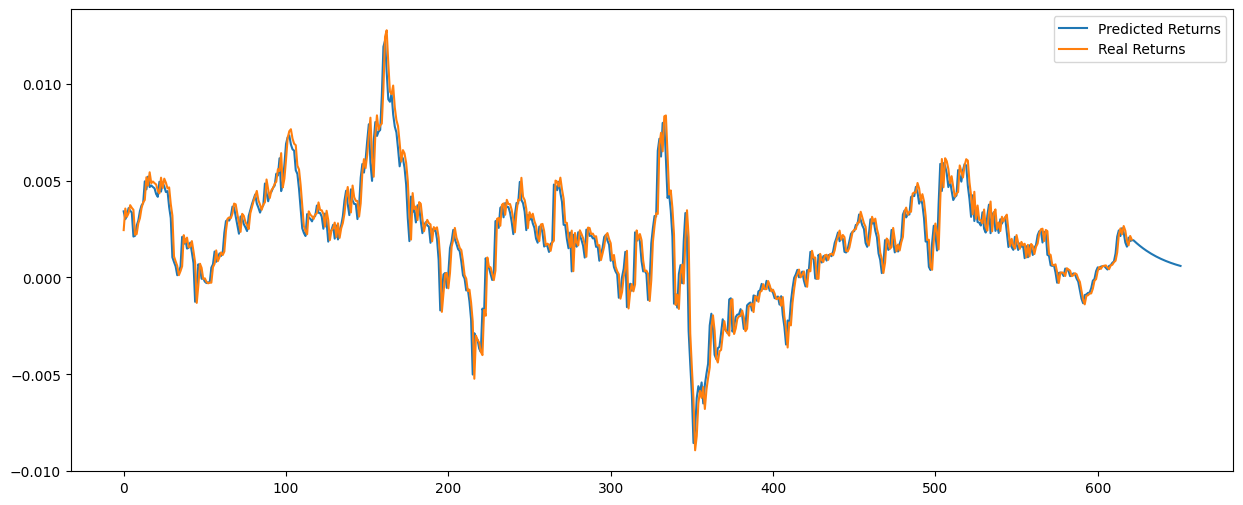

In [22]:
predict_df, real_df, average_predict = linear_df('./data/OIL.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.8741989750034
GB RMSE:  9.745283182028783e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.37621334195137024

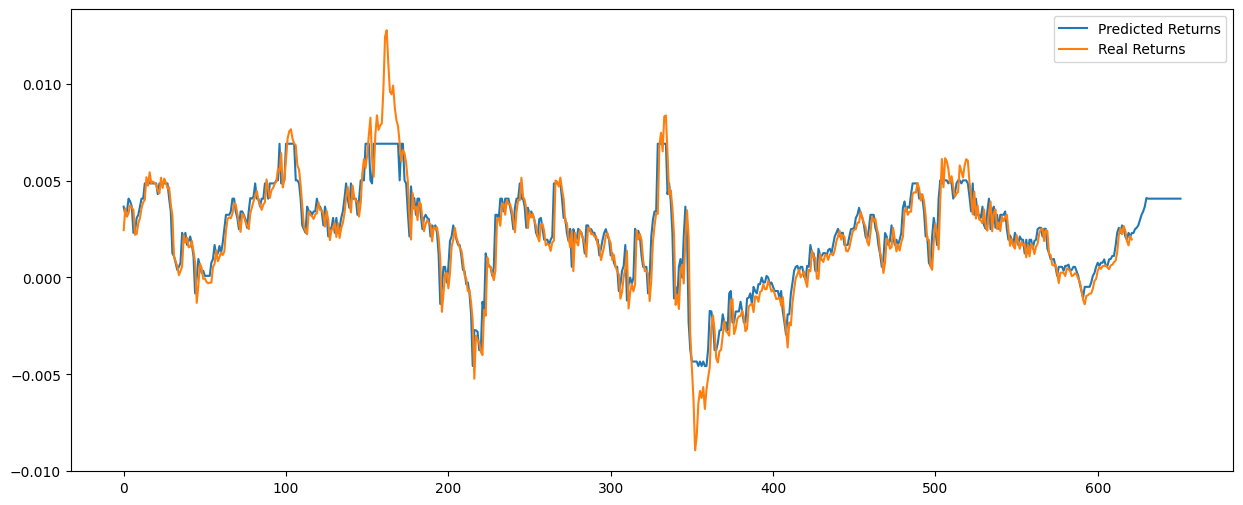

In [24]:
predict_df, real_df, average_predict = xgb_df('./data/OIL.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

## Gujarat Gas Limited (GUJGASLTD)

0.8883215968128914
kNN RMSE:  5.542729066610376e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

-0.031329684578770056

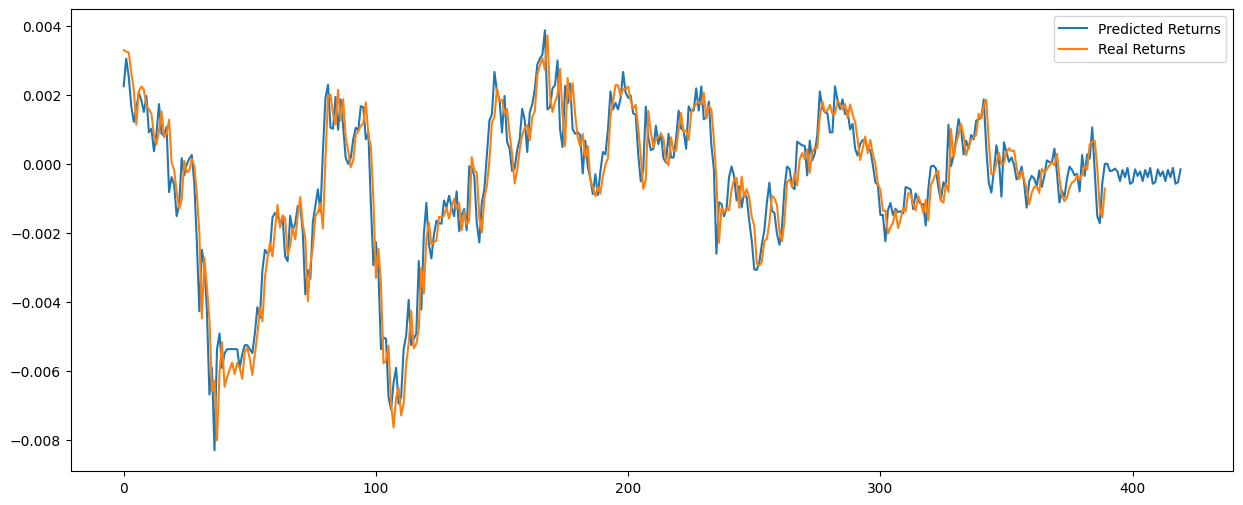

In [26]:
predict_df, real_df, average_predict = knn_df('./data/GUJGASLTD.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9057292331200344
LR RMSE:  4.6787678262358264e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

-0.08652769035491872

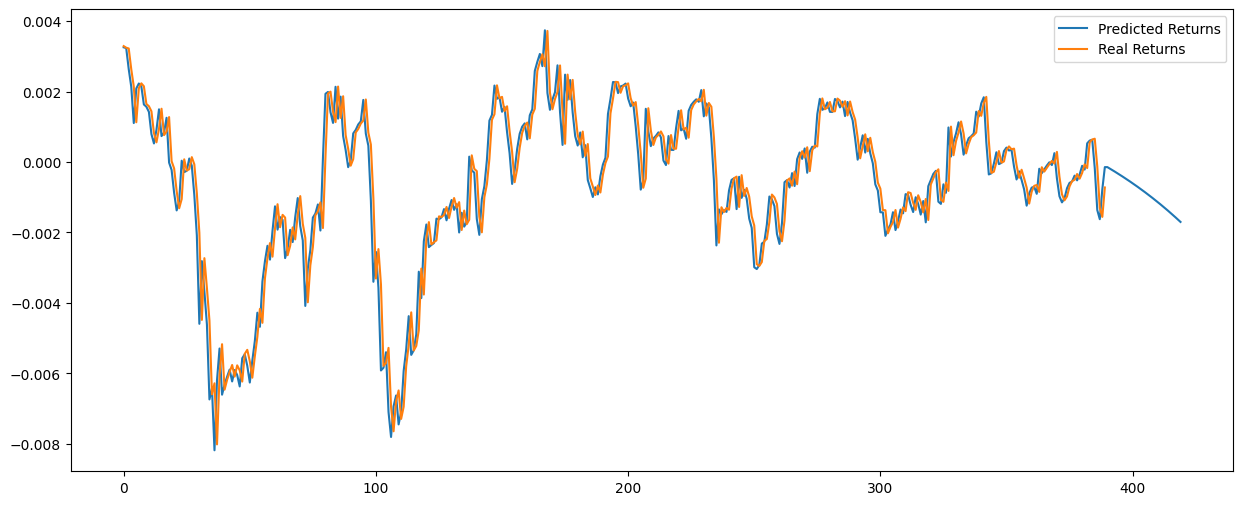

In [28]:
predict_df, real_df, average_predict = linear_df('./data/GUJGASLTD.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.8819928368423865
GB RMSE:  5.856832786246717e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.18478890415281057

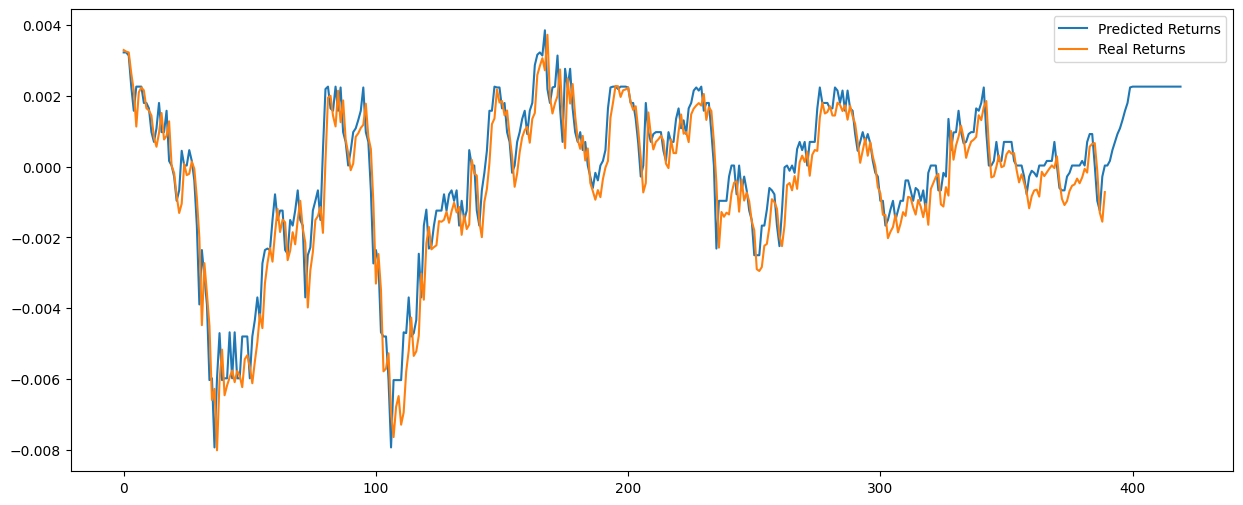

In [29]:
predict_df, real_df, average_predict = xgb_df('./data/GUJGASLTD.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

## Hindustan Petroleum Corporation Limited (HINDPETRO)

0.8979629926488181
kNN RMSE:  5.841313424343795e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

-0.08531571464611439

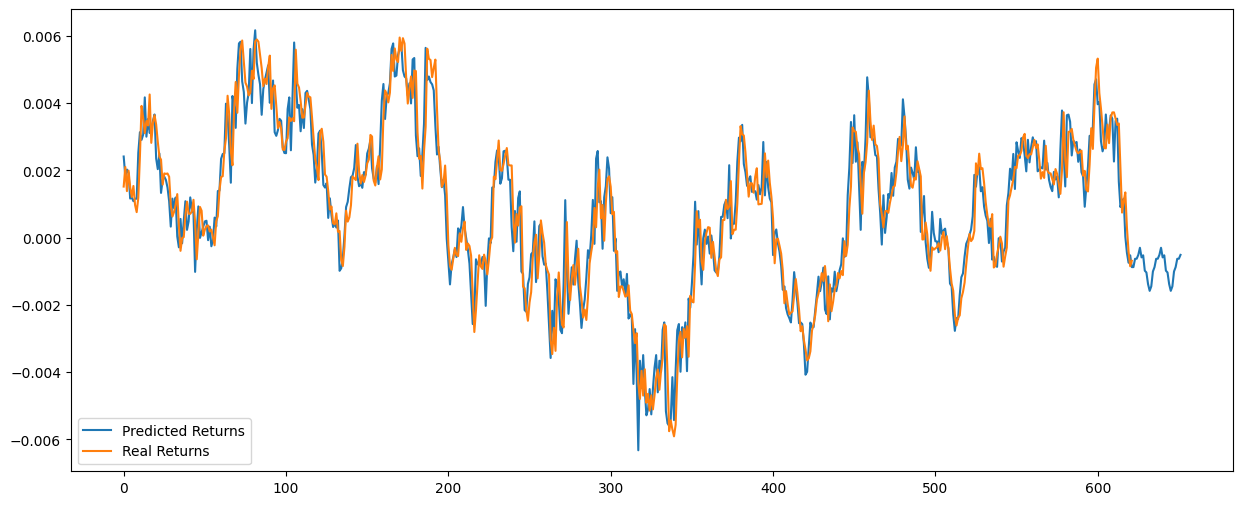

In [30]:
predict_df, real_df, average_predict = knn_df('./data/HINDPETRO.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9244371842570182
LR RMSE:  4.3257451530460235e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

-0.0429010749678623

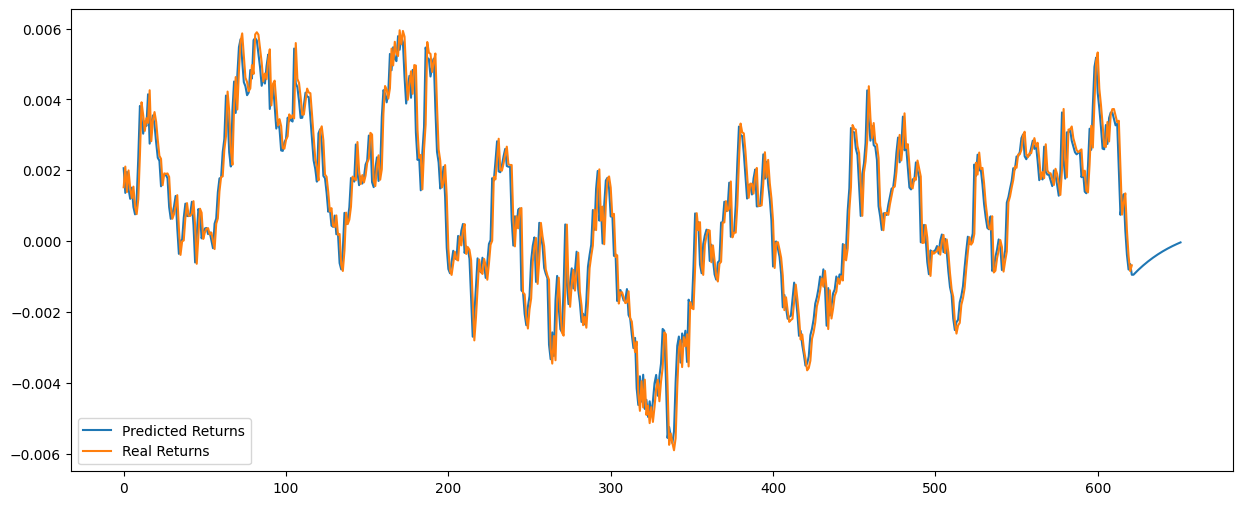

In [31]:
predict_df, real_df, average_predict = linear_df('./data/HINDPETRO.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9072836968271615
GB RMSE:  5.307730993276306e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.31180076766759157

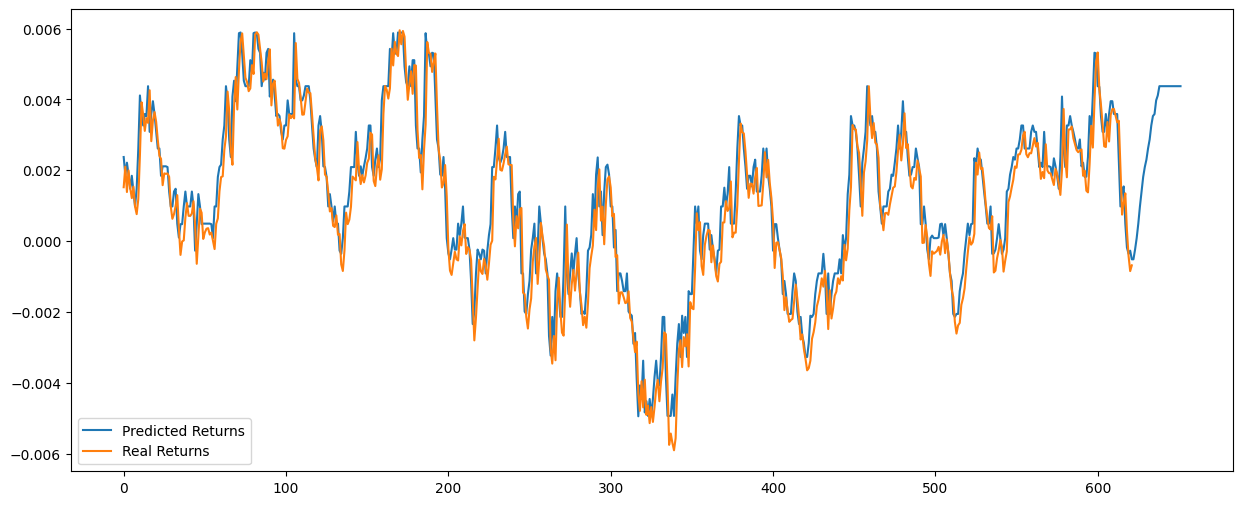

In [32]:
predict_df, real_df, average_predict = xgb_df('./data/HINDPETRO.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

## Petronet (PETRONET)

0.7833728630255352
kNN RMSE:  2.8927015867101335e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.0639568096730407

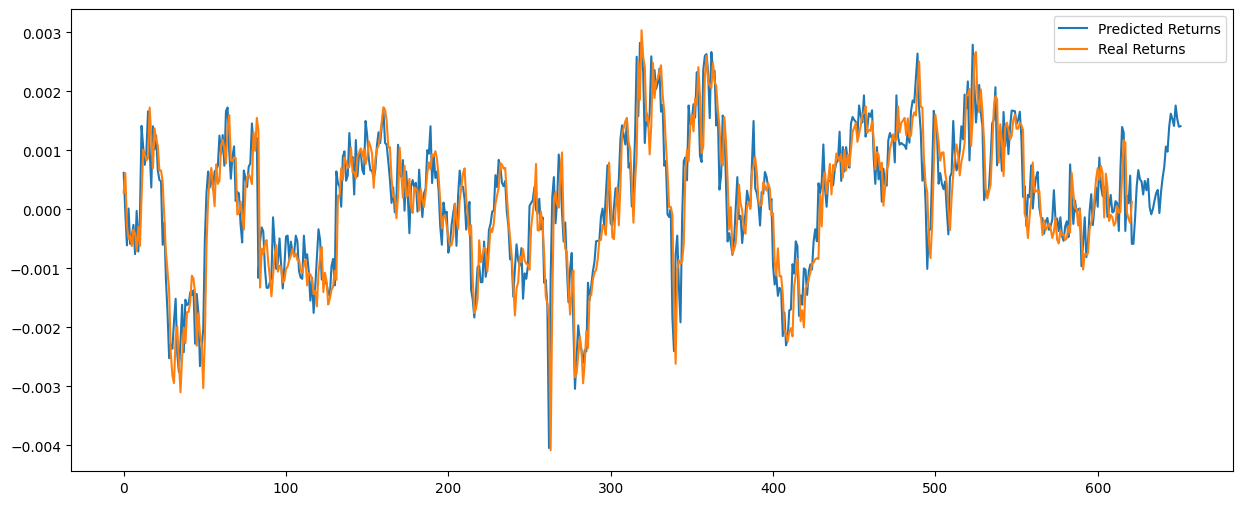

In [33]:
predict_df, real_df, average_predict = knn_df('./data/PETRONET.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.8384343703011294
LR RMSE:  2.1574450916684354e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.042928303609050866

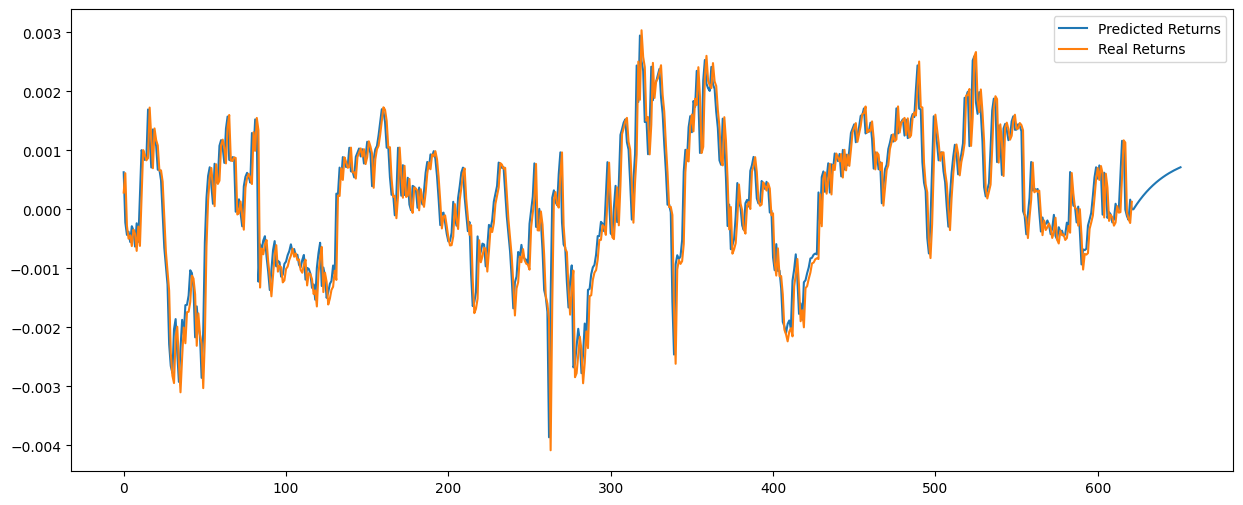

In [34]:
predict_df, real_df, average_predict = linear_df('./data/PETRONET.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.7497457230566398
GB RMSE:  3.341737116160046e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.2932523610070348

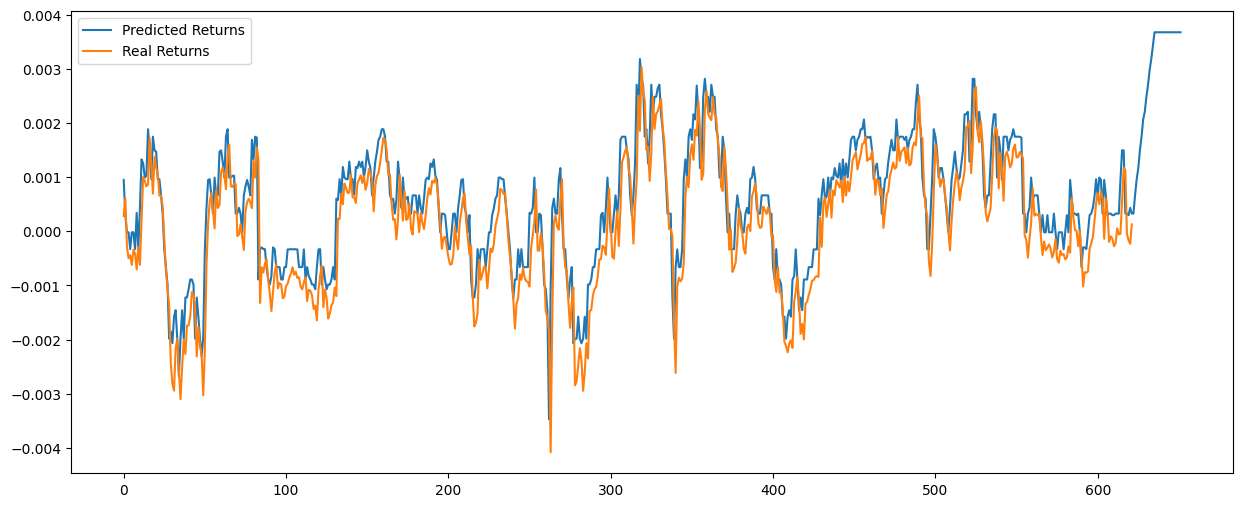

In [35]:
predict_df, real_df, average_predict = xgb_df('./data/PETRONET.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

## Indian Oil Corporation Limited (IOC)

0.9086001520870043
kNN RMSE:  3.324116100153254e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.008813007805505986

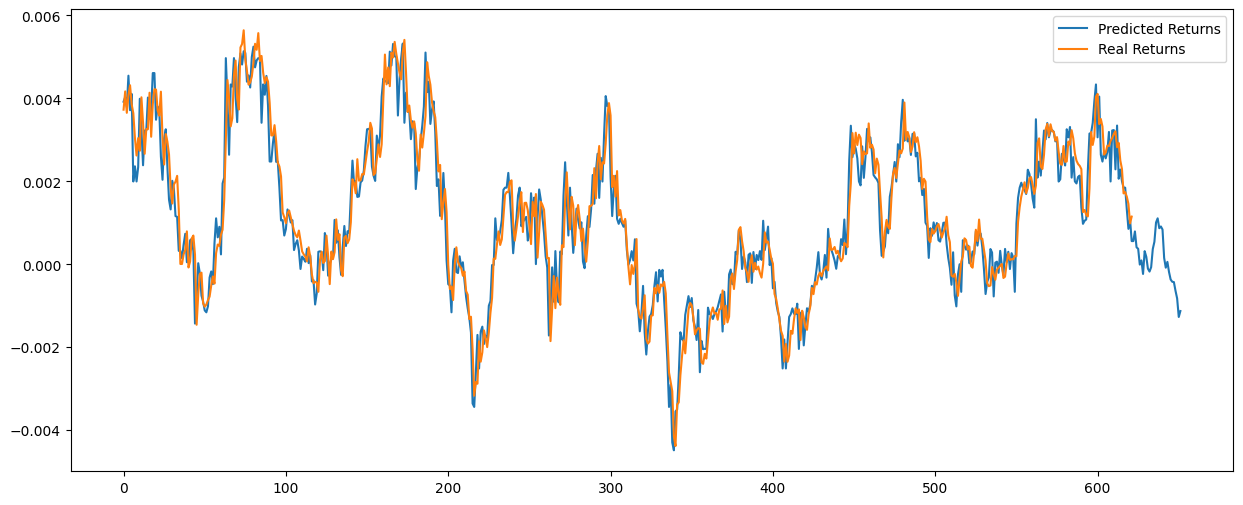

In [36]:
predict_df, real_df, average_predict = knn_df('./data/IOC.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9332735461362747
LR RMSE:  2.4267707732476973e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.0633965935345216

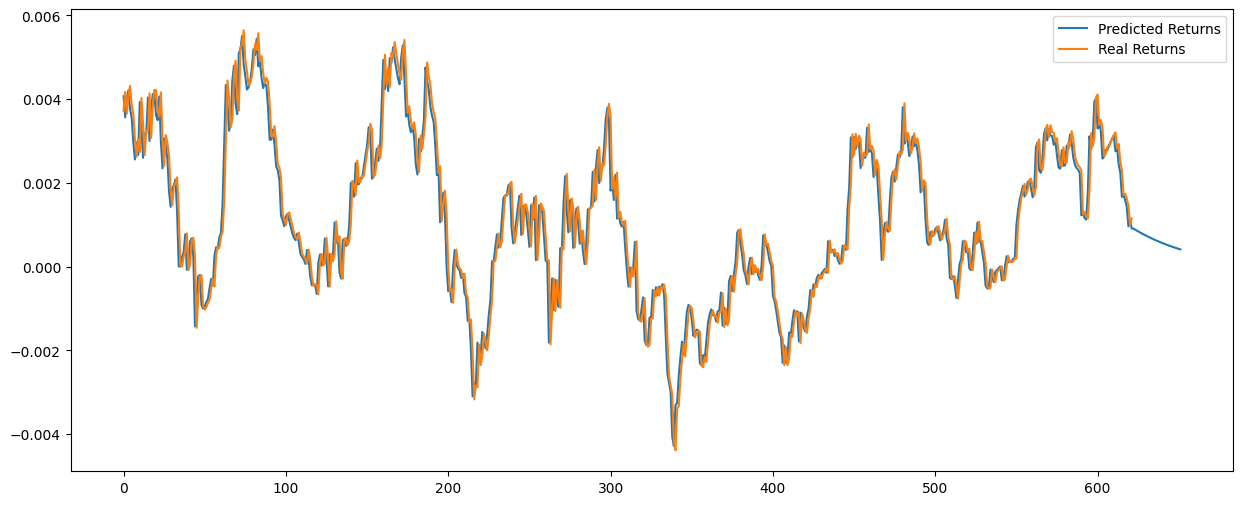

In [37]:
predict_df, real_df, average_predict = linear_df('./data/IOC.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.908885237419195
GB RMSE:  3.313747847204357e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.2194831846281886

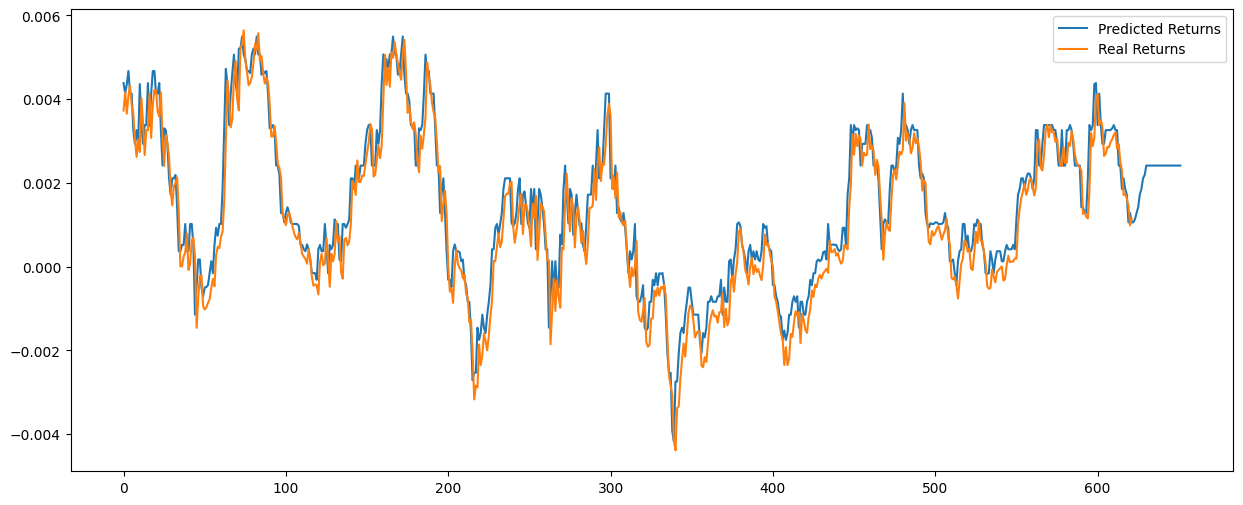

In [38]:
predict_df, real_df, average_predict = xgb_df('./data/IOC.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

## Reliance Industries Ltd (RELIANCE)

0.869689102687354
kNN RMSE:  3.1948468873671057e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.022421257453220562

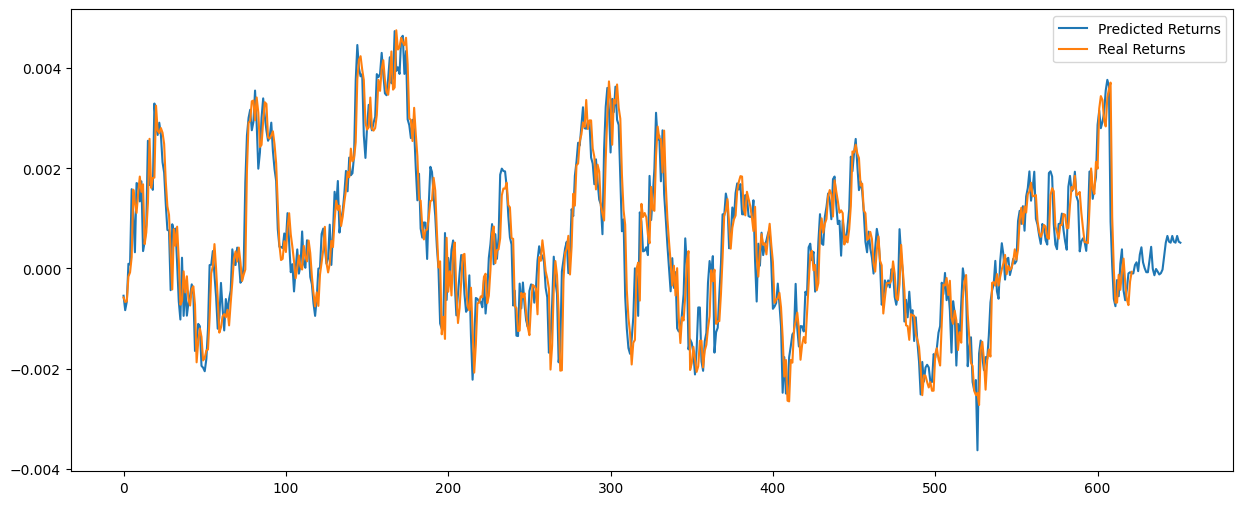

In [39]:
predict_df, real_df, average_predict = knn_df('./data/RELIANCE.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.8907012266066422
LR RMSE:  2.679690288150018e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.013982814376824679

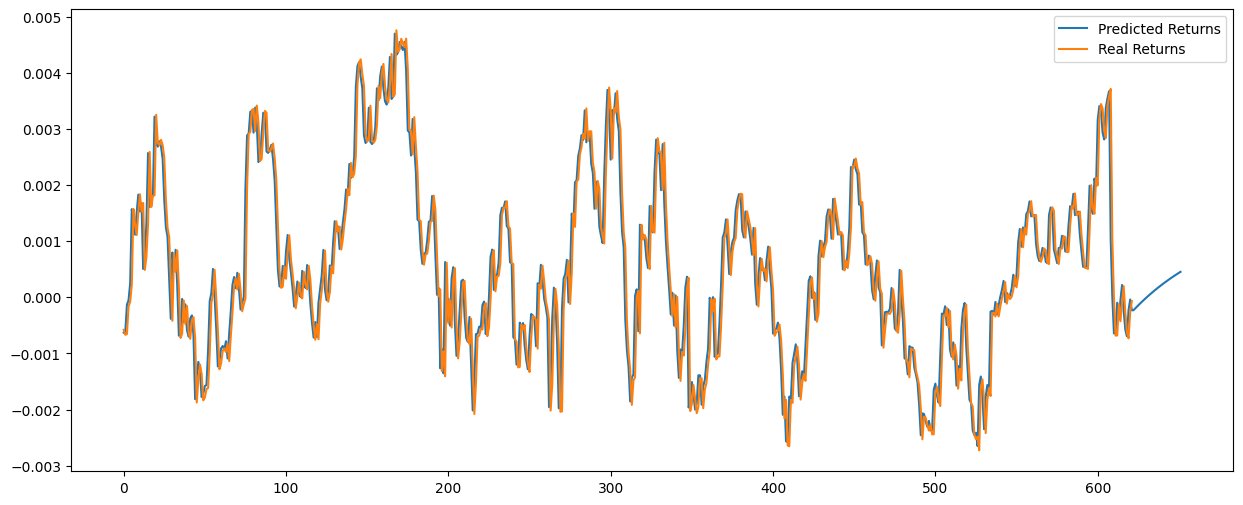

In [40]:
predict_df, real_df, average_predict = linear_df('./data/RELIANCE.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.85217667972482
GB RMSE:  3.6242009256396857e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.2110050991177559

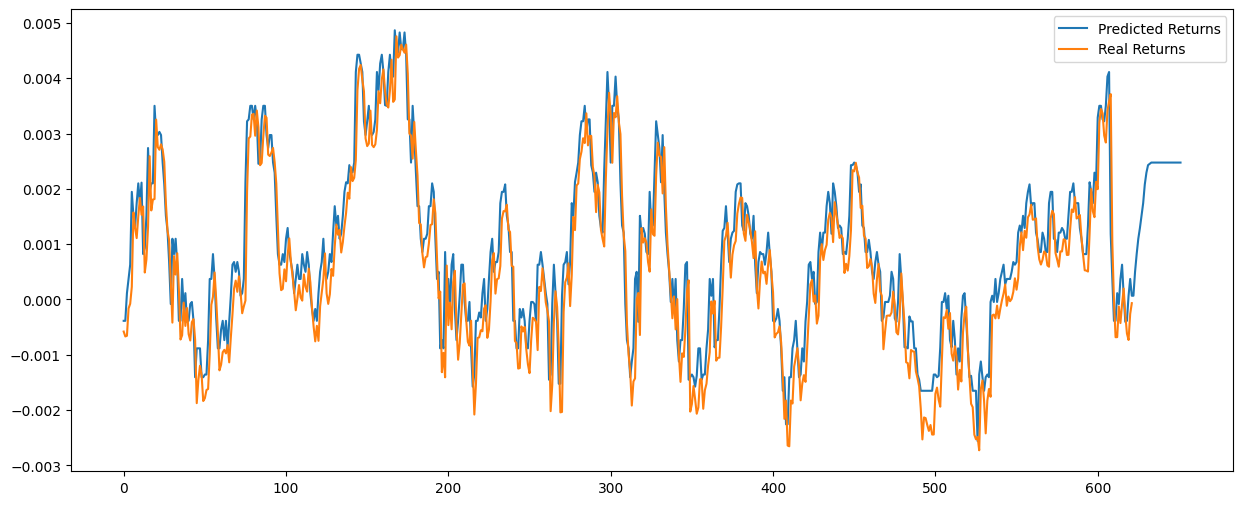

In [41]:
predict_df, real_df, average_predict = xgb_df('./data/RELIANCE.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

## Chennai Petroleum Corporation (CHENNPETRO)

0.938157068831007
kNN RMSE:  1.7876900247946466e-06


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.26205699085100265

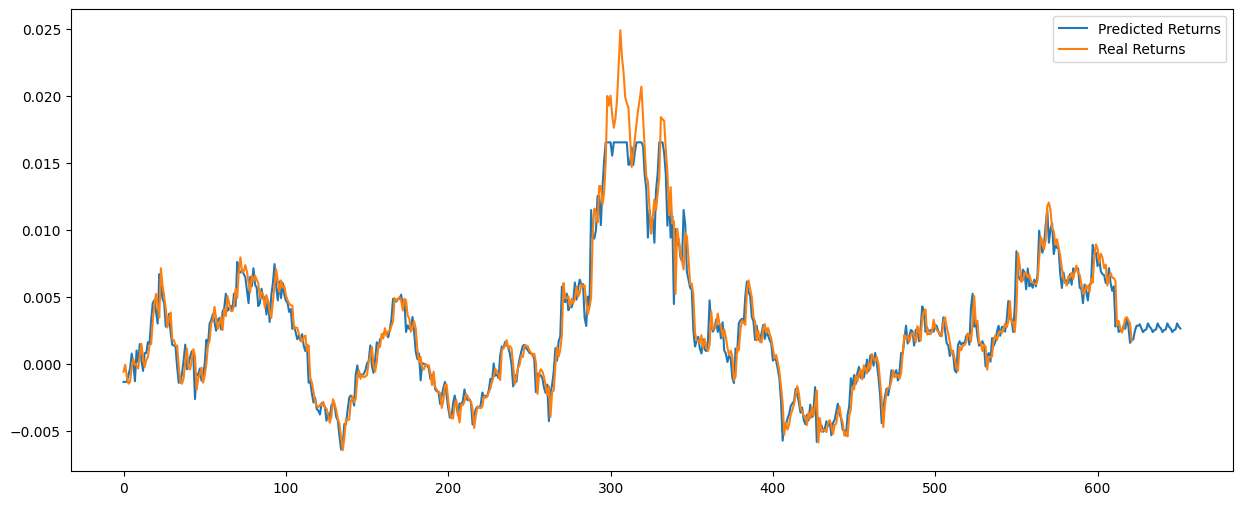

In [42]:
predict_df, real_df, average_predict = knn_df('./data/CHENNPETRO.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9601545024183837
LR RMSE:  1.1518114877994149e-06


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.14515096370863262

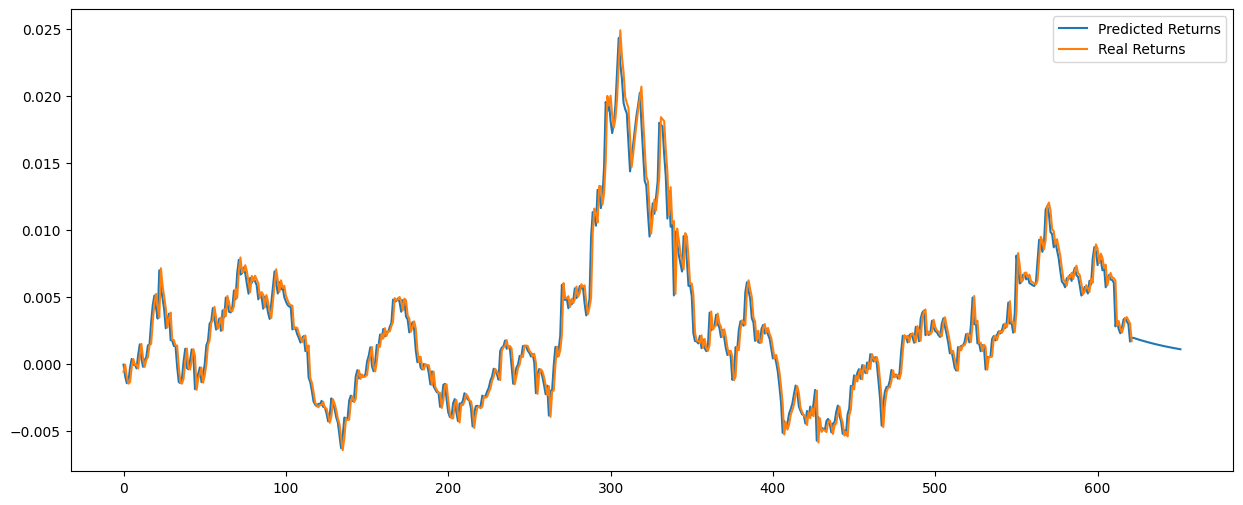

In [43]:
predict_df, real_df, average_predict = linear_df('./data/CHENNPETRO.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9523678512230567
GB RMSE:  1.3768997623251335e-06


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.32819334883242846

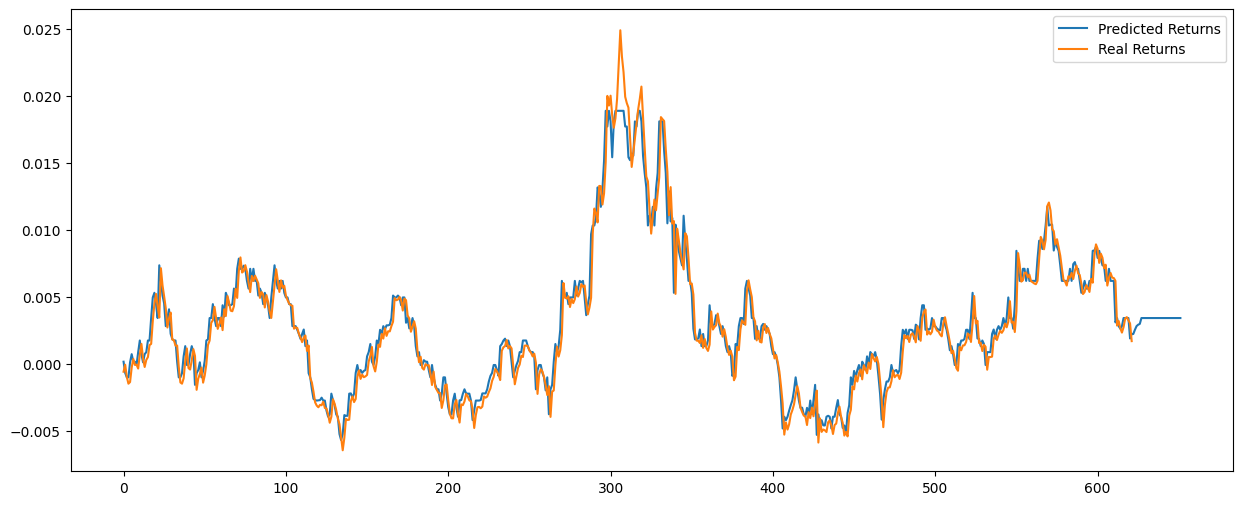

In [44]:
predict_df, real_df, average_predict = xgb_df('./data/CHENNPETRO.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

## Mangalore Refinery & Petrochemicals (MRPL)

0.9313337055407974
kNN RMSE:  1.3561221031902017e-06


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.3002362451231048

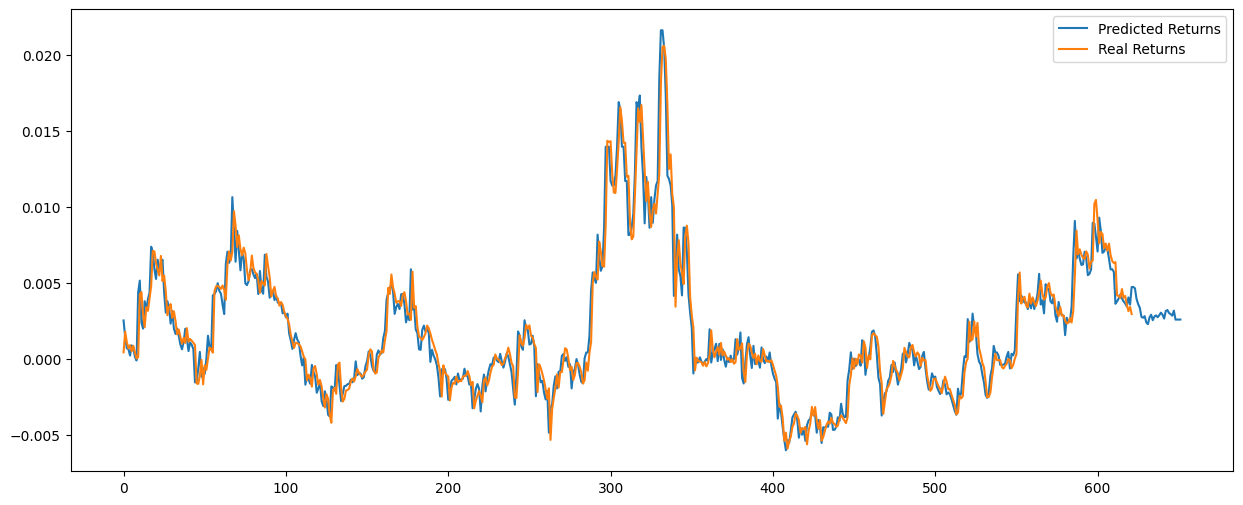

In [45]:
predict_df, real_df, average_predict = knn_df('./data/MRPL.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9410361917830953
LR RMSE:  1.1645032579808316e-06


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.3397575036319884

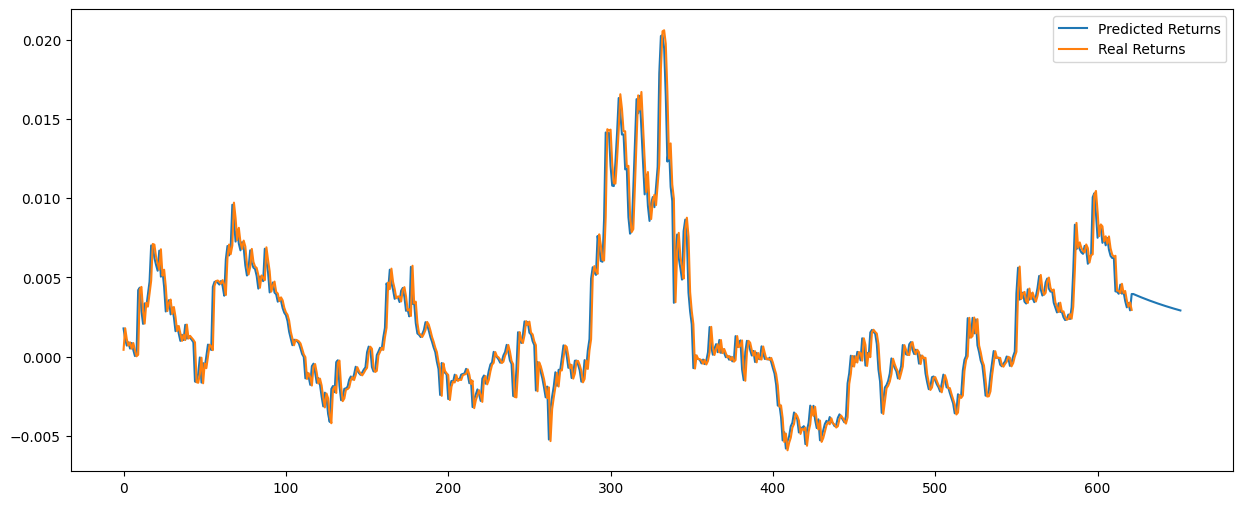

In [46]:
predict_df, real_df, average_predict = linear_df('./data/MRPL.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9290398780196787
GB RMSE:  1.4014239536365395e-06


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.42223576456308365

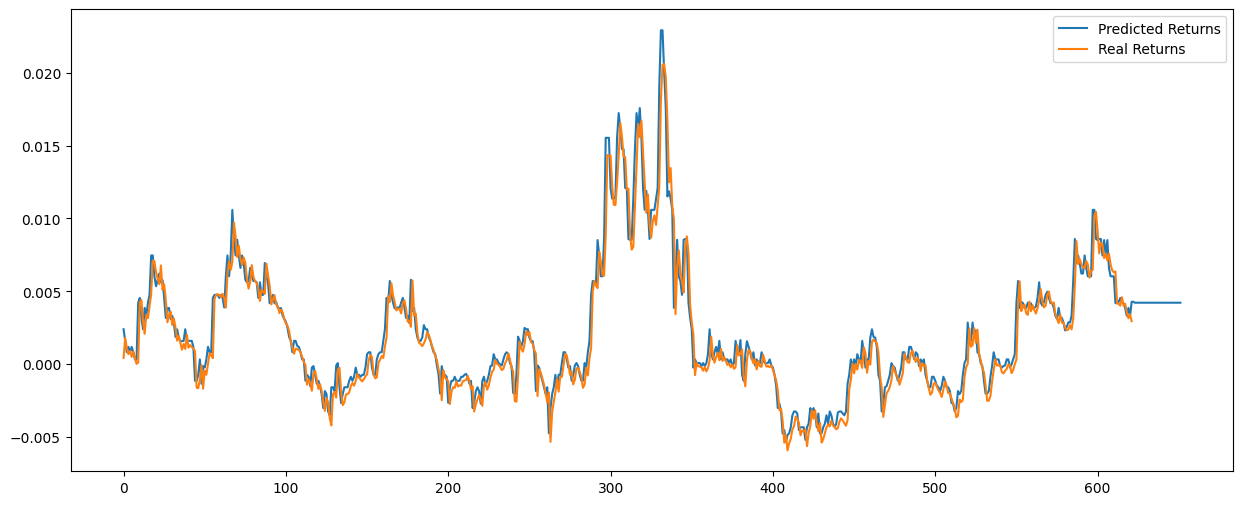

In [47]:
predict_df, real_df, average_predict = xgb_df('./data/MRPL.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

## Bharat Petroleum Corporation Limited (BPCL)

0.8847992608635926
kNN RMSE:  3.5202330136886105e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

-0.07503320737918392

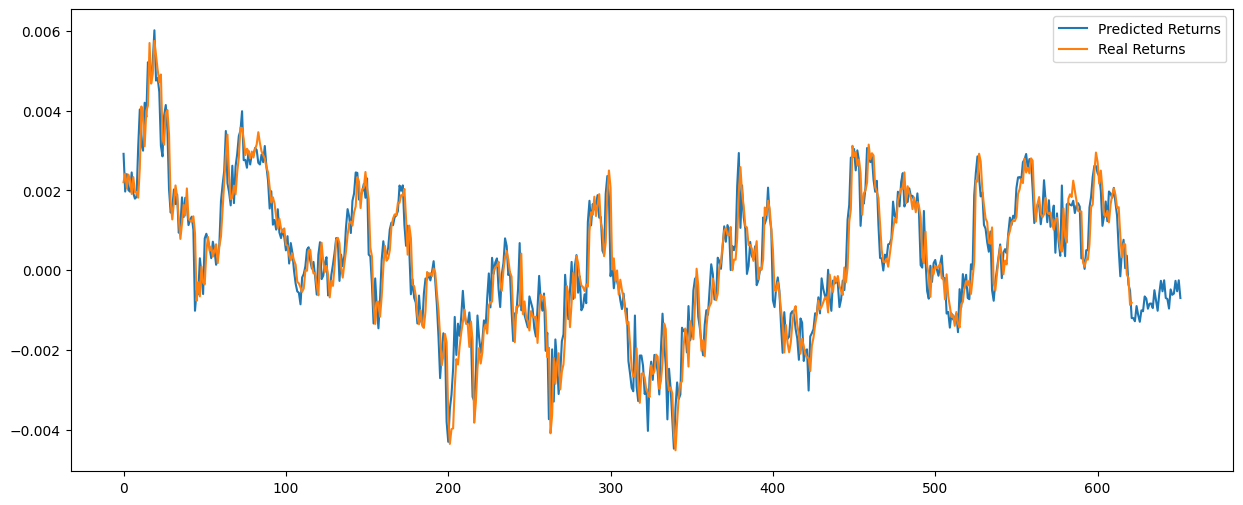

In [48]:
predict_df, real_df, average_predict = knn_df('./data/BPCL.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.9114322442201077
LR RMSE:  2.7063987625592764e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

-0.04052337139088524

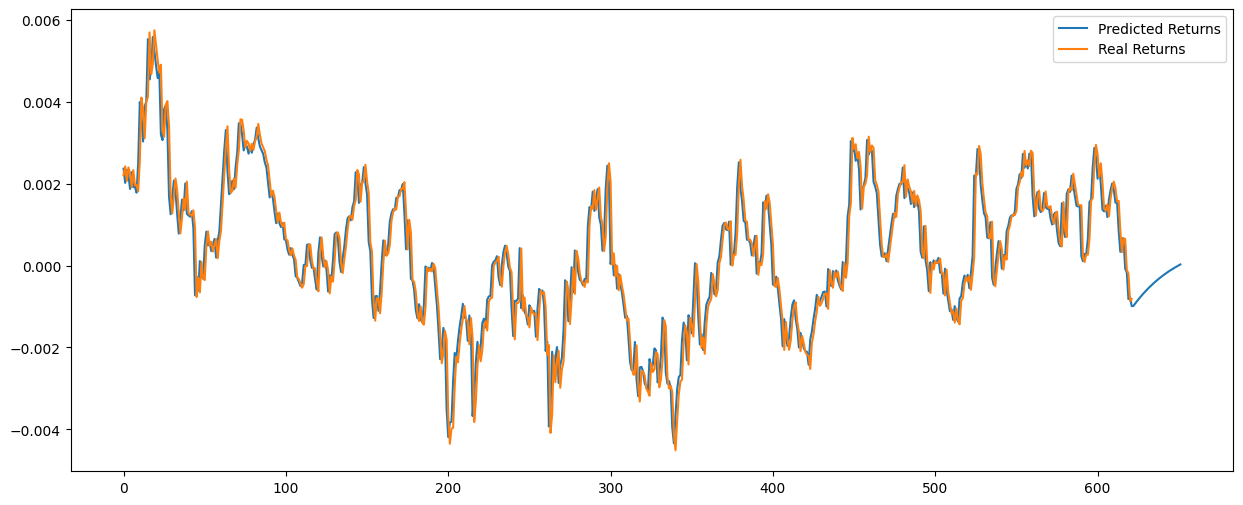

In [49]:
predict_df, real_df, average_predict = linear_df('./data/BPCL.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100

0.8704088946869268
GB RMSE:  3.9599649327189597e-07


/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Daily Return'] = return_df['Adj Close'].pct_change()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return_df['Historical Return'] = return_df['Daily Return'].ewm(alpha=alpha, adjust=False).mean()
/var/folders/_4/3164fhf93kz6lm46g0y0h2gc0000gn/T/ipykernel_96714/3941445349.py:22: SettingWit

0.23655402474105358

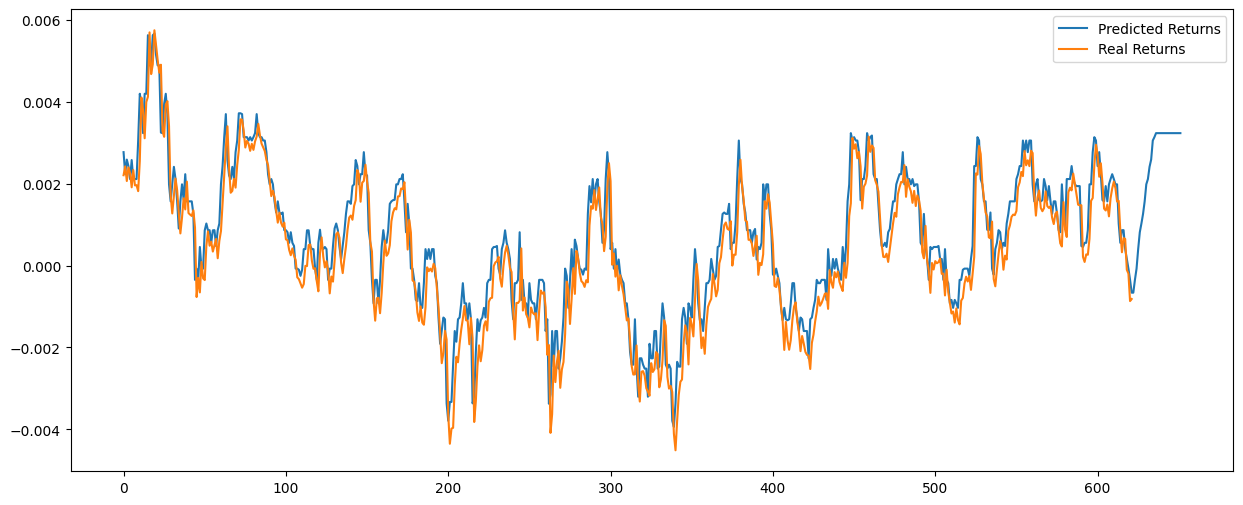

In [50]:
predict_df, real_df, average_predict = xgb_df('./data/BPCL.NS.csv', 60)
plot_result(predict_df, real_df)
average_predict*100